In [165]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import os
from env import get_db_url
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
import wrangle_zillow
import scipy.stats as stats
alpha = .05
from sklearn.cluster import KMeans

### Acquire

In [2]:
df = wrangle_zillow.get_zillow_data()

In [3]:
df.shape

(52441, 68)

### Prepare

In [4]:
# remove rows and columns with more than 30% missing data
df = wrangle_zillow.prepare_zillow_data(df)

In [7]:
# split data
train, validate, test = wrangle_zillow.split_zillow_data(df)

In [8]:
train.shape, validate.shape, test.shape

((21728, 15), (9312, 15), (7761, 15))

### Explore

Ask at least 5 questions about the data, keeping in mind that your target variable is logerror. e.g. Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?

Answer those questions through a mix of statistical tests and visualizations.

Bonus:

Compute the mean(logerror) by zipcode and the overall mean(logerror). Write a loop that will run a t-test between the overall mean and the mean for each zip code. We want to identify the zip codes where the error is significantly higher or lower than the expected error.

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bathroomcnt,38801.0,2.057151e+00,0.698323,1.000000e+00,2.000000e+00,2.000000e+00,2.500000e+00,4.000000e+00
bedroomcnt,38801.0,3.190201e+00,0.776164,2.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00
calculatedfinishedsquarefeet,38801.0,1.639604e+03,564.940706,1.520000e+02,1.224000e+03,1.530000e+03,1.960000e+03,3.522000e+03
latitude,38801.0,3.401946e+07,270521.732089,3.334425e+07,3.382814e+07,3.399394e+07,3.418931e+07,3.471836e+07
longitude,38801.0,-1.181861e+08,351178.645614,-1.194753e+08,-1.183744e+08,-1.181343e+08,-1.179375e+08,-1.175723e+08
lotsizesquarefeet,38801.0,6.623087e+03,2026.022353,1.350000e+03,5.410000e+03,6.500000e+03,7.663000e+03,1.243400e+04
regionidcity,38801.0,3.465884e+04,52651.990158,3.491000e+03,1.244700e+04,2.481200e+04,4.022700e+04,3.965560e+05
regionidzip,38801.0,9.658180e+04,1594.948267,9.598200e+04,9.621200e+04,9.642600e+04,9.700100e+04,3.996750e+05
yearbuilt,38801.0,1.961764e+03,20.327878,1.913000e+03,1.950000e+03,1.959000e+03,1.975000e+03,2.012000e+03
taxvaluedollarcnt,38801.0,3.517464e+05,223455.330328,3.254000e+03,1.675160e+05,3.241530e+05,4.949560e+05,1.070530e+06


In [10]:
df.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,regionidcity,regionidzip,yearbuilt,taxvaluedollarcnt,taxamount,logerror,transactiondate,propertylandusedesc
0,3.5,4,3100,Orange,33634931,-117869207,4506,53571,96978,1998,1023282,11013,0.025595,2017-01-01,Single Family Residential
2,2.0,3,1243,Orange,33886168,-117823170,8432,21412,97078,1962,564778,6488,0.005383,2017-01-01,Single Family Residential
5,1.0,2,738,Los_Angeles,34149214,-118239357,4214,45457,96325,1922,218552,2366,0.101723,2017-01-01,Single Family Residential
7,3.0,4,2540,Los_Angeles,34434971,-118464390,10384,54311,96374,1999,430108,6103,0.005963,2017-01-02,Single Family Residential
9,2.5,3,1371,Ventura,34238229,-119170633,3445,13150,97107,2004,198054,2204,0.008669,2017-01-02,Single Family Residential


In [16]:
#looking at the counts for each column
for column in df.columns:
    print(column)
    print(df[column].value_counts())
    print("-------------------------------")

bathroomcnt
2.0    18983
1.0     7885
3.0     7107
2.5     3303
1.5      619
4.0      595
3.5      309
Name: bathroomcnt, dtype: int64
-------------------------------
bedroomcnt
3    19339
4    10763
2     6927
5     1772
Name: bedroomcnt, dtype: int64
-------------------------------
calculatedfinishedsquarefeet
1120    122
1200     99
1080     81
936      79
1400     77
       ... 
2913      1
3462      1
2877      1
3009      1
512       1
Name: calculatedfinishedsquarefeet, Length: 2775, dtype: int64
-------------------------------
fips
Los_Angeles    25033
Orange         10485
Ventura         3283
Name: fips, dtype: int64
-------------------------------
latitude
34229075    4
33914773    4
34712133    4
33873860    4
34267979    3
           ..
34043478    1
34173982    1
33926793    1
33728790    1
33937685    1
Name: latitude, Length: 37641, dtype: int64
-------------------------------
longitude
-117847000    5
-117830000    4
-117849000    4
-118398581    4
-117762000    4
     

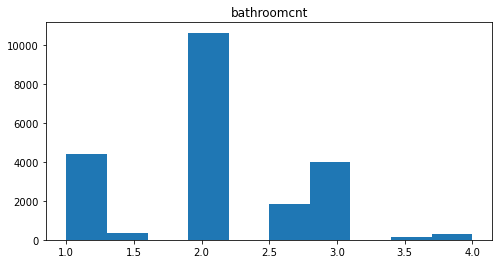

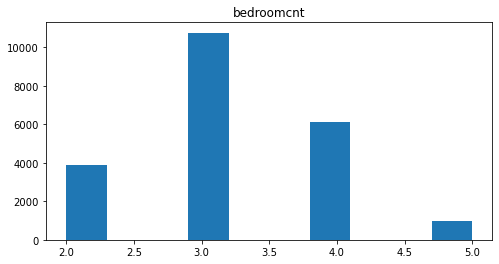

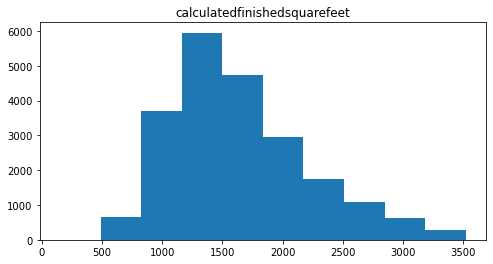

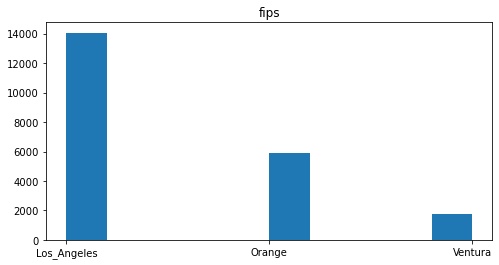

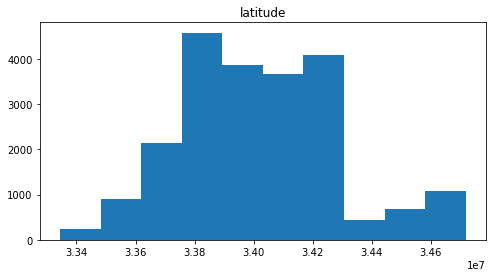

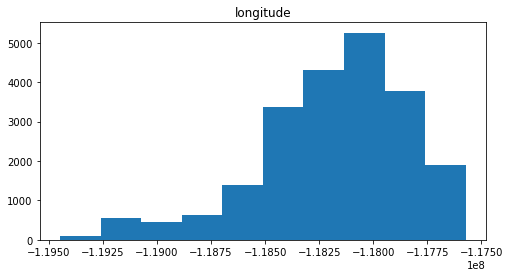

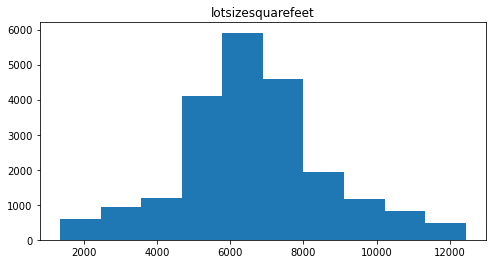

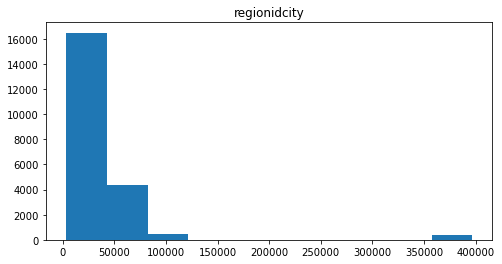

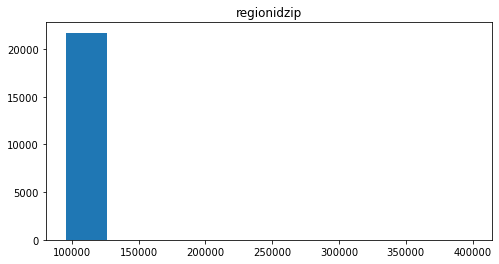

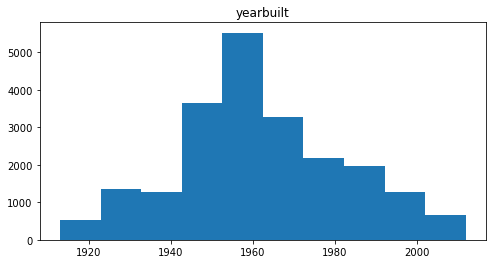

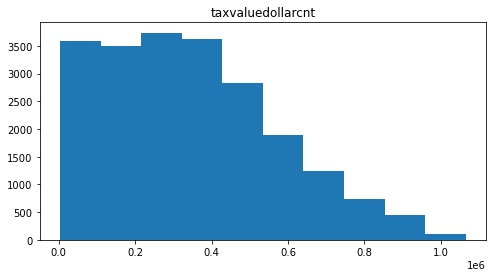

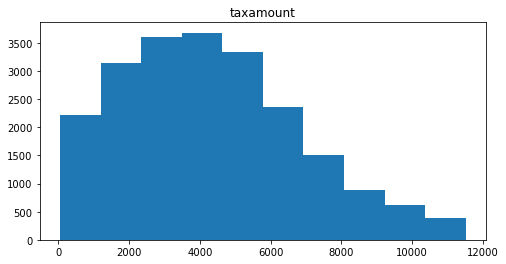

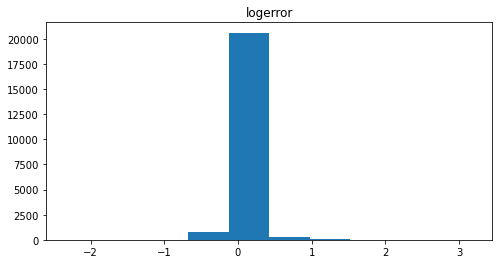

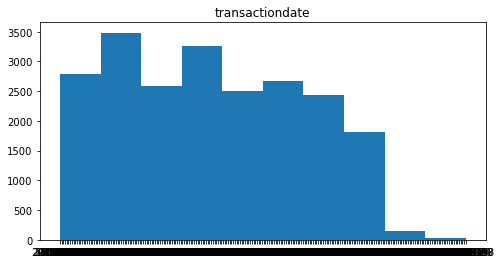

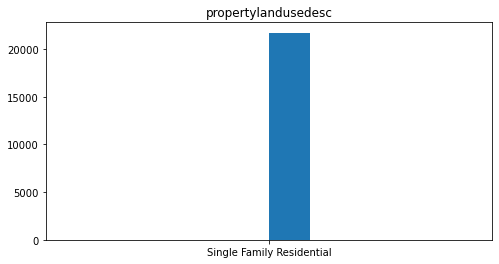

In [11]:
#create all the histograms:
for col in train.columns:
    plt.figure(figsize=(8,4))
    plt.hist(train[col])
    plt.title(col)
    plt.show()

### Questions to ask:
   - Is logerror dependent on county?
   - Are logerror and tax value related?
   - Are logerror and lot size related?
   - Are logerror and squarefeet related?
    

<AxesSubplot:xlabel='fips', ylabel='logerror'>

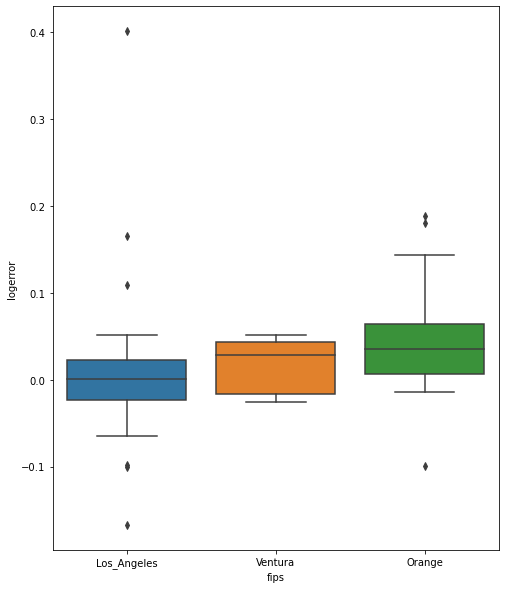

In [21]:
plt.figure(figsize=(8,10))
sns.boxplot(x=train.fips.sample(1000), y=train.logerror.sample(1000))

**Notes:**
- LA county's median value is more closely centered around zero, while Ventura and Orange County have higher median logerror. 
- Outliers exist in both LA and Orange counties

Next step:
- Run statistical tests to determine if there is a difference in each county and the population mean.

- Null Hypothesis: The mean logerror of LA County is >= than the population mean.
- Alternative Hypothesis: The mean logerror of LA County is < than the population mean.

In [77]:
t, p = stats.ttest_1samp(train[train.fips=='Los_Angles'].logerror.mean(), df.logerror.mean())

t, p/2
if p/2 > alpha:
    print("We fail to reject the null hypothesis.")
elif t > 0:
    print("We fail to reject the null hypothesis.")
else:
    print("We reject the null hypothesis.")


We reject the null hypothesis.


- Null Hypothesis: The mean logerror of Ventura County is <= than the population mean.
- Alternative Hypothesis: The mean logerror of Ventura County is > than the population mean.

In [91]:
t, p = stats.ttest_1samp(train[train.fips=='Ventura'].logerror.mean(), df.logerror.mean())
t, p/2
if p/2 > alpha:
    print("We fail to reject the null hypothesis.")
elif t < 0:
    print("We fail to reject the null hypothesis.")
else:
    print("We reject the null hypothesis.")

We reject the null hypothesis.


- Null Hypothesis: The mean logerror of Orange County is <= than the population mean.
- Alternative Hypothesis: The mean logerror of Orange County is > than the population mean.

In [78]:
t, p = stats.ttest_1samp(train[train.fips=='Orange'].logerror.mean(), df.logerror.mean())
t, p/2
if p/2 > alpha:
    print("We fail to reject the null hypothesis.")
elif t < 0:
    print("We fail to reject the null hypothesis.")
else:
    print("We reject the null hypothesis.")

We reject the null hypothesis.


**Notes: We can conclude, with statistical significance, that the means of the logerror of each county are not equal. LA County's logerror is less than the population, while Orange and Ventura counties' logerror means are greater than the population.**

### Logerror and taxvaluedollarcnt

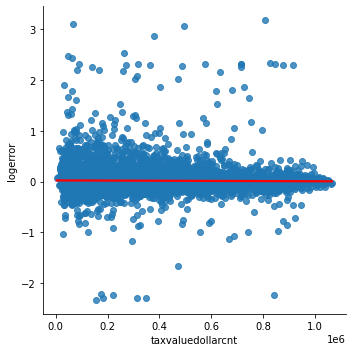

In [151]:
sns.lmplot(data=train, x='taxvaluedollarcnt',y='logerror',line_kws={'color':'red'})
plt.show()

<AxesSubplot:>

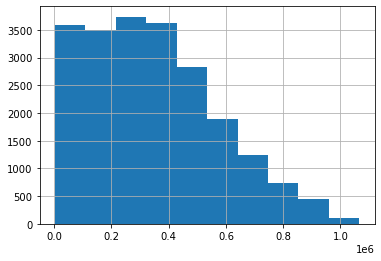

In [162]:
train.taxvaluedollarcnt.hist()

In [119]:
# perform correlation testing on square feet to value
alpha=.05
corr, p = stats.spearmanr(train.taxvaluedollarcnt, train.logerror)
p < alpha, corr, p

(False, -0.009619933852524446, 0.15619954117451582)

In [154]:
corr = pd.DataFrame(train.corr(method='spearman'))
corr

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,regionidcity,regionidzip,yearbuilt,taxvaluedollarcnt,taxamount,logerror
bathroomcnt,1.000000,0.567875,0.788266,-0.021224,0.115461,0.143177,0.012897,0.305933,0.605786,0.333486,0.340444,0.050648
bedroomcnt,0.567875,1.000000,0.613704,0.003718,0.070756,0.219338,0.022241,0.248545,0.415431,0.166317,0.176616,0.046402
calculatedfinishedsquarefeet,0.788266,0.613704,1.000000,-0.035241,0.093949,0.270736,0.015193,0.263213,0.532038,0.364303,0.369713,0.062921
latitude,-0.021224,0.003718,-0.035241,1.000000,-0.639187,0.314863,-0.181988,0.124467,-0.003511,-0.165432,-0.100355,-0.029925
longitude,0.115461,0.070756,0.093949,-0.639187,1.000000,-0.085111,0.115153,0.289255,0.227210,0.055008,0.034191,0.029892
lotsizesquarefeet,0.143177,0.219338,0.270736,0.314863,-0.085111,1.000000,-0.051469,0.190504,0.029480,-0.002825,0.014265,-0.004917
regionidcity,0.012897,0.022241,0.015193,-0.181988,0.115153,-0.051469,1.000000,0.043823,0.023437,0.071251,0.064289,0.022351
regionidzip,0.305933,0.248545,0.263213,0.124467,0.289255,0.190504,0.043823,1.000000,0.570815,0.051112,0.050116,0.030217
yearbuilt,0.605786,0.415431,0.532038,-0.003511,0.227210,0.029480,0.023437,0.570815,1.000000,0.230771,0.241328,0.040874
taxvaluedollarcnt,0.333486,0.166317,0.364303,-0.165432,0.055008,-0.002825,0.071251,0.051112,0.230771,1.000000,0.971708,-0.009620


In [155]:
corr.logerror

bathroomcnt                     0.050648
bedroomcnt                      0.046402
calculatedfinishedsquarefeet    0.062921
latitude                       -0.029925
longitude                       0.029892
lotsizesquarefeet              -0.004917
regionidcity                    0.022351
regionidzip                     0.030217
yearbuilt                       0.040874
taxvaluedollarcnt              -0.009620
taxamount                      -0.015615
logerror                        1.000000
Name: logerror, dtype: float64

In [156]:
corr_p = pd.DataFrame(train.corr(method='pearson'))
corr_p

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,regionidcity,regionidzip,yearbuilt,taxvaluedollarcnt,taxamount,logerror
bathroomcnt,1.000000,0.574887,0.771876,0.019810,0.050280,0.158058,-0.061112,0.058442,0.568751,0.332524,0.338531,0.020621
bedroomcnt,0.574887,1.000000,0.604539,0.029173,0.012466,0.221295,-0.051591,0.045799,0.379954,0.168227,0.175911,0.022630
calculatedfinishedsquarefeet,0.771876,0.604539,1.000000,-0.022319,0.048381,0.275389,-0.054896,0.050994,0.513067,0.402272,0.404267,0.022037
latitude,0.019810,0.029173,-0.022319,1.000000,-0.531576,0.292855,-0.001631,0.027175,0.095435,-0.217839,-0.130847,-0.025321
longitude,0.050280,0.012466,0.048381,-0.531576,1.000000,-0.109094,-0.014597,0.039751,0.099905,0.036985,0.023817,0.019491
lotsizesquarefeet,0.158058,0.221295,0.275389,0.292855,-0.109094,1.000000,-0.014722,0.017334,-0.003053,0.012969,0.026859,-0.006037
regionidcity,-0.061112,-0.051591,-0.054896,-0.001631,-0.014597,-0.014722,1.000000,-0.023010,-0.106653,0.007717,-0.001390,0.001379
regionidzip,0.058442,0.045799,0.050994,0.027175,0.039751,0.017334,-0.023010,1.000000,0.111585,0.002036,-0.000282,0.001255
yearbuilt,0.568751,0.379954,0.513067,0.095435,0.099905,-0.003053,-0.106653,0.111585,1.000000,0.229418,0.247459,0.009418
taxvaluedollarcnt,0.332524,0.168227,0.402272,-0.217839,0.036985,0.012969,0.007717,0.002036,0.229418,1.000000,0.967099,-0.023741


In [157]:
corr_p.logerror

bathroomcnt                     0.020621
bedroomcnt                      0.022630
calculatedfinishedsquarefeet    0.022037
latitude                       -0.025321
longitude                       0.019491
lotsizesquarefeet              -0.006037
regionidcity                    0.001379
regionidzip                     0.001255
yearbuilt                       0.009418
taxvaluedollarcnt              -0.023741
taxamount                      -0.027835
logerror                        1.000000
Name: logerror, dtype: float64

In [143]:
def calculate_pvalues_spearman(df):
    df = df.select_dtypes(include=['number'])
    pairs = pd.MultiIndex.from_product([df.columns, df.columns])
    pvalues = [stats.spearmanr(df[a], df[b])[1] for a, b in pairs]
    pvalues = pd.Series(pvalues, index=pairs).unstack().round(4)
    return pvalues

In [144]:
pvalues_s = calculate_pvalues_spearman(train)

In [161]:
pvalues_s.logerror < alpha

bathroomcnt                      True
bedroomcnt                       True
calculatedfinishedsquarefeet     True
latitude                         True
logerror                         True
longitude                        True
lotsizesquarefeet               False
regionidcity                     True
regionidzip                      True
taxamount                        True
taxvaluedollarcnt               False
yearbuilt                        True
Name: logerror, dtype: bool

In [146]:
def calculate_pvalues_pearson(df):
    df = df.select_dtypes(include=['number'])
    pairs = pd.MultiIndex.from_product([df.columns, df.columns])
    pvalues = [stats.pearsonr(df[a], df[b])[1] for a, b in pairs]
    pvalues = pd.Series(pvalues, index=pairs).unstack().round(4)
    return pvalues

In [147]:
pvalues_p = calculate_pvalues_pearson(train)

In [160]:
pvalues_p.logerror < alpha

bathroomcnt                      True
bedroomcnt                       True
calculatedfinishedsquarefeet     True
latitude                         True
logerror                         True
longitude                        True
lotsizesquarefeet               False
regionidcity                    False
regionidzip                     False
taxamount                        True
taxvaluedollarcnt                True
yearbuilt                       False
Name: logerror, dtype: bool

Things to look into:
- p > alpha on yearbuilt, regionidzip, regionidcity, lotsizesquarefeet on pearson corr
- p > alpha on lotsizesquarefeet and taxvaluedollarcnt on spearman corr
- extremely weak correlation between logerror and all values
- highest correlation between log error and calculatedfinishedsquarefeet at 0.062921 with spearman 

### Clustering

In [163]:
X = train[['longitude', 'latitude']]

In [166]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

kmeans.predict(X)

array([1, 1, 2, ..., 2, 2, 2], dtype=int32)

In [167]:
train['clusters'] = kmeans.predict(X)

In [169]:
train.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,regionidcity,regionidzip,yearbuilt,taxvaluedollarcnt,taxamount,logerror,transactiondate,propertylandusedesc,clusters
46193,3.0,3,3391,Los_Angeles,34685313,-118214036,6823,5534,97319,2005,234716,5002,0.047455,2017-08-18,Single Family Residential,1
51180,3.0,4,2353,Los_Angeles,34279115,-118549987,9634,12447,96356,1973,307922,3878,-0.031543,2017-09-12,Single Family Residential,1
13479,2.0,4,1244,Los_Angeles,33860844,-118113043,6149,12292,96213,1955,455633,5443,-0.013747,2017-03-24,Single Family Residential,2
9373,4.0,4,2629,Los_Angeles,34175075,-118552823,4951,12447,96379,1991,804691,9752,0.056647,2017-03-02,Single Family Residential,1
24417,2.0,3,1191,Los_Angeles,33891889,-118099406,5377,53636,96193,1954,50283,940,-0.116277,2017-05-15,Single Family Residential,2


Text(0.5, 1.0, 'K-Means Clusters')

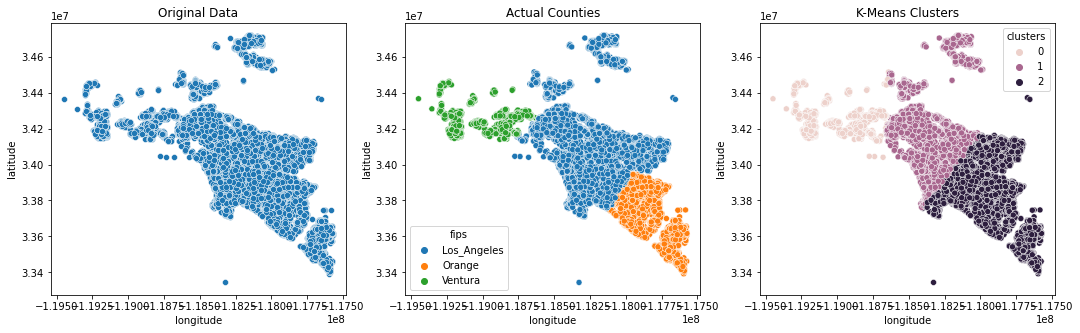

In [170]:
plt.figure(figsize=(18,5))
plt.subplot(131)
sns.scatterplot(data = train, x = 'longitude', y = 'latitude')
plt.title('Original Data')

plt.subplot(132)
sns.scatterplot(data = train, x = 'longitude', y = 'latitude', hue = 'fips')
plt.title('Actual Counties')

plt.subplot(133)
sns.scatterplot(data = train, x = 'longitude', y = 'latitude', hue = 'clusters')
plt.title('K-Means Clusters')

<Figure size 1440x2160 with 0 Axes>

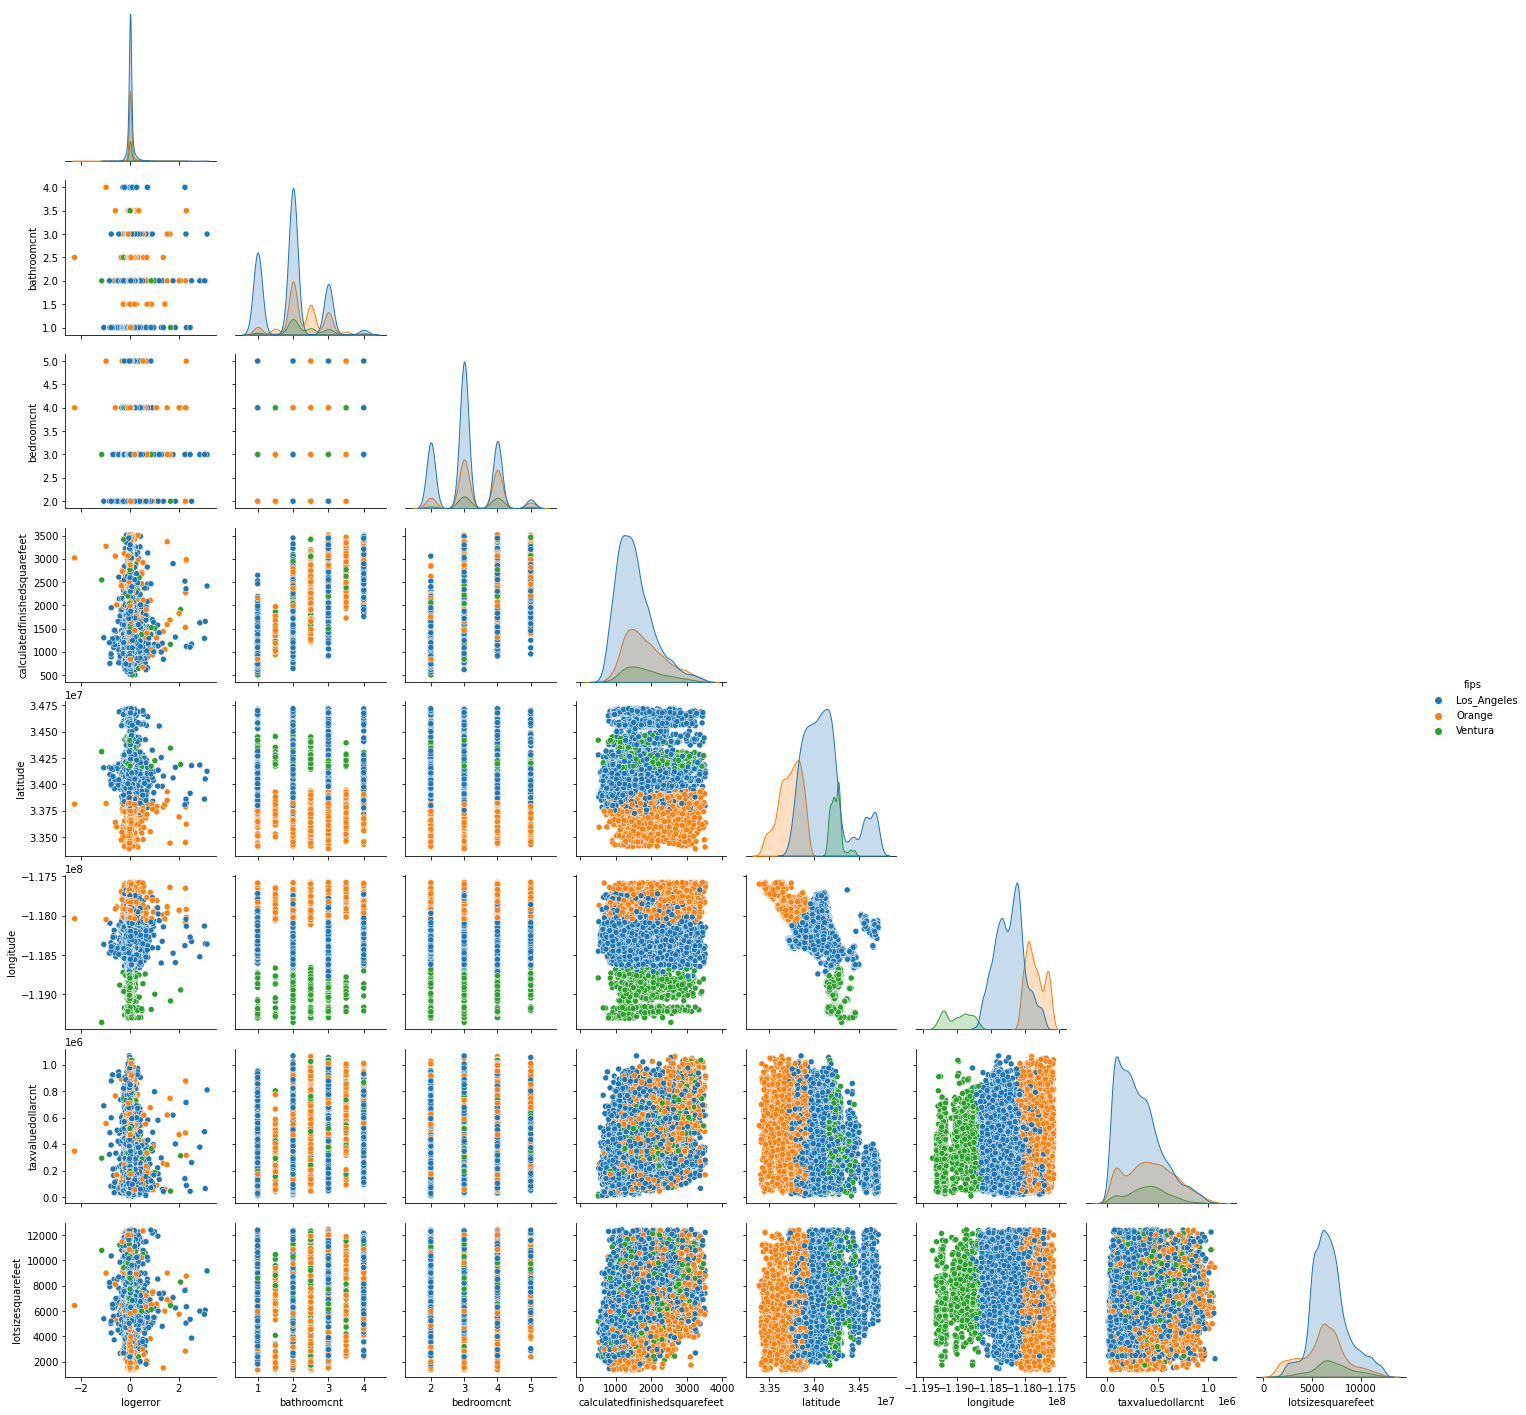

In [63]:
plt.figure(figsize = (20,30))
sns.pairplot(data=train.sample(10000), x_vars=['logerror','bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latitude', 'longitude', 'taxvaluedollarcnt', 'lotsizesquarefeet'],
                  y_vars=['logerror','bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latitude', 'longitude', 'taxvaluedollarcnt', 'lotsizesquarefeet'], hue = "fips", corner=True)


**Latitude and longitude make clear county clusters**